# Speech Recognition System

Data: Free Spoken Digit Dataset
https://github.com/Jakobovski/free-spoken-digit-dataset

    4 speakers
    10 digits
    50 recordings of each digit --> 2000 total recording
    We will train the model on three speakers and test the model on 1 speaker to avoid data leakage
    
1. Extracting the labels
2. Exploratory data analysis 
3. Extracting audio features

In [1]:
# Importing all the required libraries
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Frequently used plot functions

In [2]:

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Signal in time domain', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Signal in Frequency domain', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

### Data exploration

In [3]:
#Extracting labels

digit = []
labels=os.listdir('../Data/')
for label in labels:
    digit.append(label.split('_')[0])
df = pd.DataFrame(digit,labels,columns=['Digit'])
df.head(6)

,Digit
5_nicolas_9.wav,5
3_yweweler_14.wav,3
4_yweweler_38.wav,4
3_yweweler_28.wav,3
4_yweweler_10.wav,4
1_nicolas_15.wav,1


In [4]:
#Reading the audio file and calculating the length
for f in df.index:
    rate, signal = wavfile.read('../data/'+f)
    df.at[f,'length (sec)'] = signal.shape[0]/rate
df.head(6)

,Digit,length (sec)
5_nicolas_9.wav,5,0.337375
3_yweweler_14.wav,3,0.305750
4_yweweler_38.wav,4,0.383125
3_yweweler_28.wav,3,0.284000
4_yweweler_10.wav,4,0.362250
1_nicolas_15.wav,1,0.293625


In [20]:
#Finding the number of recordings for each digit
classes = pd.DataFrame(df.groupby('Digit').count())
classes.rename(columns = {'length (sec)': 'count'})

,count
Digit,
0,200
1,200
2,200
3,200
4,200
5,200
6,200
7,200
8,200


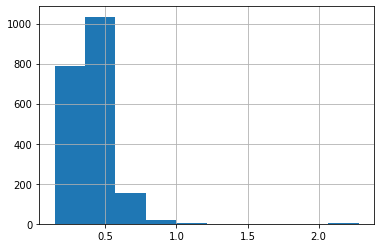

In [23]:
#Duration of the recordings
df['length (sec)'].hist()